In [1]:
import arff
import pandas as pd
import os
from pyunpack import Archive
import pprint
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = './data/emotion/'
rar_path = data_dir+'emotions.rar'
output_dir = data_dir+'extracted_files'


In [2]:
# Archive(rar_path).extractall(output_dir)
# extracted the rar file (i already did this so dont do it agian tho)

In [3]:
train_arff = data_dir+"emotions/emotions-train.arff"
test_arff = data_dir+"emotions/emotions-test.arff"

## Quick Look at the data
it looks like the data has many features (76) including things like the centroid, and all the MFCC constants (these are normalized fft info that are normalized to the sound that we perceive. It also has a lot of these flux / rolloff values which i'm not entirely sure the meaning of these)
The data has 391 data points.

The last couple features:  
'amazed-suprised',
 'happy-pleased',
 'relaxing-calm',
 'quiet-still',
 'sad-lonely',
 'angry-aggresive'
 are our target variables, these are the labeled emotions. 
 
 Looking at just these features, it seems like they are already one hot encoded with a 1 if it is that emotion and 0 otherwise. They are not mutually exclusive/ a data point can have multiple emotions marked.

 Additionally, it looks like we will want to normalize the data as most values are between 0-1 except for a couple of features.

In [4]:
#training data
with open(train_arff) as f:
    train_data = arff.load(f)
train_df = pd.DataFrame(train_data['data'], columns=[attr[0] for attr in train_data['attributes']])

#testing data
with open(test_arff) as f:
    test_data = arff.load(f)
test_df = pd.DataFrame(test_data['data'], columns=[attr[0] for attr in test_data['attributes']])

print(train_df.columns.to_list())
print("Length of training data", len(train_df))
print("Length of test data", len(test_df))


['Mean_Acc1298_Mean_Mem40_Centroid', 'Mean_Acc1298_Mean_Mem40_Rolloff', 'Mean_Acc1298_Mean_Mem40_Flux', 'Mean_Acc1298_Mean_Mem40_MFCC_0', 'Mean_Acc1298_Mean_Mem40_MFCC_1', 'Mean_Acc1298_Mean_Mem40_MFCC_2', 'Mean_Acc1298_Mean_Mem40_MFCC_3', 'Mean_Acc1298_Mean_Mem40_MFCC_4', 'Mean_Acc1298_Mean_Mem40_MFCC_5', 'Mean_Acc1298_Mean_Mem40_MFCC_6', 'Mean_Acc1298_Mean_Mem40_MFCC_7', 'Mean_Acc1298_Mean_Mem40_MFCC_8', 'Mean_Acc1298_Mean_Mem40_MFCC_9', 'Mean_Acc1298_Mean_Mem40_MFCC_10', 'Mean_Acc1298_Mean_Mem40_MFCC_11', 'Mean_Acc1298_Mean_Mem40_MFCC_12', 'Mean_Acc1298_Std_Mem40_Centroid', 'Mean_Acc1298_Std_Mem40_Rolloff', 'Mean_Acc1298_Std_Mem40_Flux', 'Mean_Acc1298_Std_Mem40_MFCC_0', 'Mean_Acc1298_Std_Mem40_MFCC_1', 'Mean_Acc1298_Std_Mem40_MFCC_2', 'Mean_Acc1298_Std_Mem40_MFCC_3', 'Mean_Acc1298_Std_Mem40_MFCC_4', 'Mean_Acc1298_Std_Mem40_MFCC_5', 'Mean_Acc1298_Std_Mem40_MFCC_6', 'Mean_Acc1298_Std_Mem40_MFCC_7', 'Mean_Acc1298_Std_Mem40_MFCC_8', 'Mean_Acc1298_Std_Mem40_MFCC_9', 'Mean_Acc1298_Std_Mem

In [5]:
emotion_features = ['amazed-suprised',
 'happy-pleased',
 'relaxing-calm',
 'quiet-still',
 'sad-lonely',
 'angry-aggresive']
ignore_features = ['BH_LowPeakAmp', 'BH_LowPeakBPM', 'BH_HighPeakAmp', 'BH_HighPeakBPM', 'BH_HighLowRatio', 'BHSUM1', 'BHSUM2', 'BHSUM3']
audio_features = [feature for feature in train_df.columns if feature not in emotion_features and feature not in ignore_features]
train_df[emotion_features].head() 

,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
0,0,1,1,0,0,0
1,1,0,0,0,0,1
2,0,1,0,0,0,1
3,0,0,1,0,0,0
4,0,0,0,1,0,0


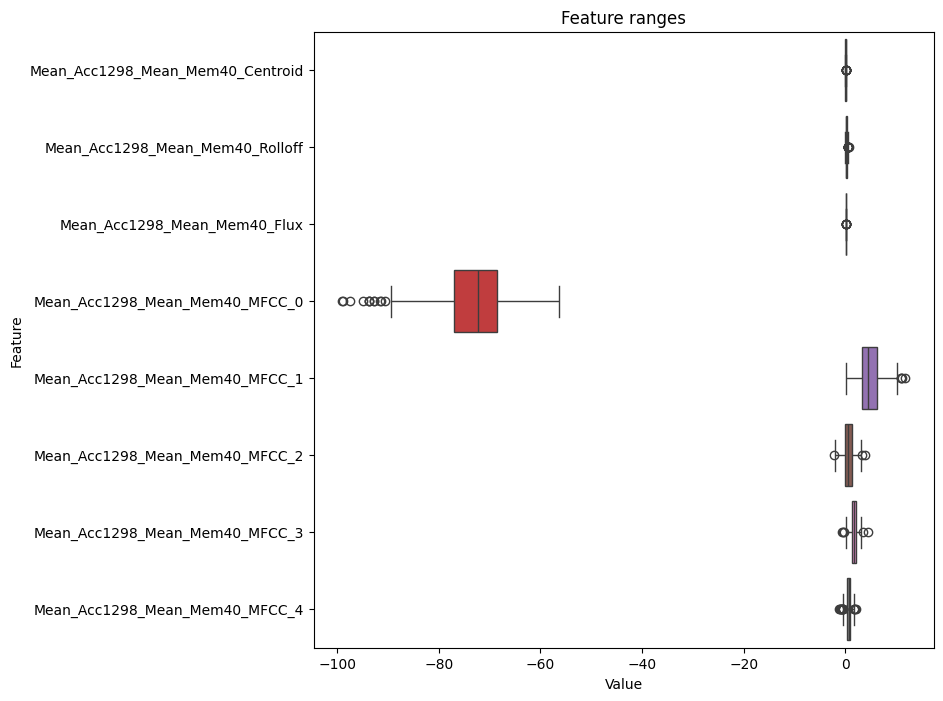

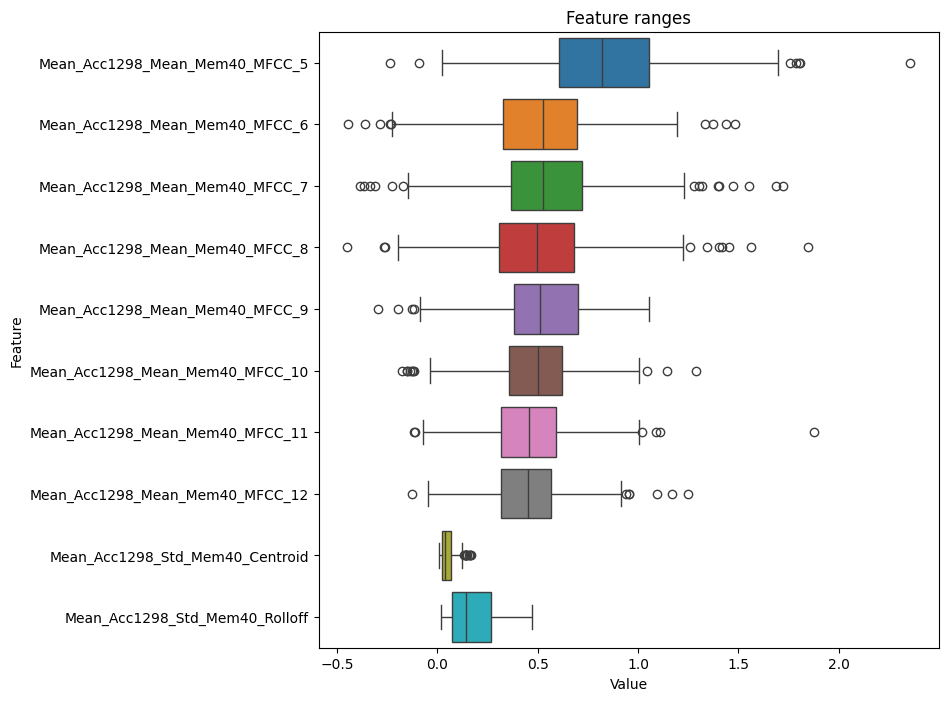

In [6]:
#Info
plt.figure(figsize=(8, 8))
plt.title('Feature ranges')
sns.boxplot(data=train_df[audio_features[:8]], orient="h")
plt.xlabel('Value')
plt.ylabel('Feature')
plt.show()

plt.figure(figsize=(8, 8))
plt.title('Feature ranges')
sns.boxplot(data=train_df[audio_features[8:18]], orient="h")
plt.xlabel('Value')
plt.ylabel('Feature')
plt.show()



## Ideas

### Supervised Learning (Classification)
Classify them by emotion

### Unsupervised Learning (Clustering)
Clustering the data based on its numerical features, then revealing the labels to see

In [7]:
#imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [8]:

#1. Normalize
scaler = MinMaxScaler()
train_df_scaled = train_df.copy()
train_df_scaled[audio_features]= scaler.fit_transform(train_df[audio_features])


In [9]:
#how correlated are different features to the different emotions?
print(train_df_scaled.cov()['amazed-suprised'].sort_values(ascending=False).head(5))
print("---")
print(train_df_scaled.cov()['relaxing-calm'].sort_values(ascending=False).head(5))

amazed-suprised    0.212263
BHSUM3             0.108695
BH_HighPeakAmp     0.060784
BHSUM2             0.054786
angry-aggresive    0.054181
Name: amazed-suprised, dtype: float64
---
BH_HighPeakBPM    2.093298
BH_LowPeakBPM     1.294583
relaxing-calm     0.245682
quiet-still       0.071178
sad-lonely        0.049184
Name: relaxing-calm, dtype: float64


In [10]:
#2. create Classification model
model = RandomForestClassifier(n_estimators=100)

#fit the model
model.fit(train_df_scaled[audio_features], train_df_scaled[emotion_features])

RandomForestClassifier()

In [11]:
#3. Run model on training data
train_predictions = model.predict(train_df_scaled[audio_features])

#4. Measure error
#I ran into some difficulty here because each emotion is a different column
# so I had to measure the accuracy for each emotion separately
for i in range(len(emotion_features)):
    accuracy = accuracy_score(train_df_scaled[emotion_features].iloc[:, i], train_predictions[:, i])
    print("Accuracy on training data for "+ emotion_features[i] + ":" + str(accuracy))


#5. Run model on test data
test_df_scaled = test_df.copy()
test_df_scaled[audio_features]= scaler.transform(test_df[audio_features])
test_predictions = model.predict(test_df_scaled[audio_features])
#6. Measure error
for i in range(len(emotion_features)):
    accuracy = accuracy_score(test_df[emotion_features].iloc[:, i], test_predictions[:, i])
    print("Accuracy on test data for "+ emotion_features[i] + ":" + str(accuracy))



Accuracy on training data for amazed-suprised:1.0
Accuracy on training data for happy-pleased:1.0
Accuracy on training data for relaxing-calm:1.0
Accuracy on training data for quiet-still:1.0
Accuracy on training data for sad-lonely:1.0
Accuracy on training data for angry-aggresive:1.0
Accuracy on test data for amazed-suprised:0.7871287128712872
Accuracy on test data for happy-pleased:0.7623762376237624
Accuracy on test data for relaxing-calm:0.7326732673267327
Accuracy on test data for quiet-still:0.8712871287128713
Accuracy on test data for sad-lonely:0.7970297029702971
Accuracy on test data for angry-aggresive:0.8168316831683168


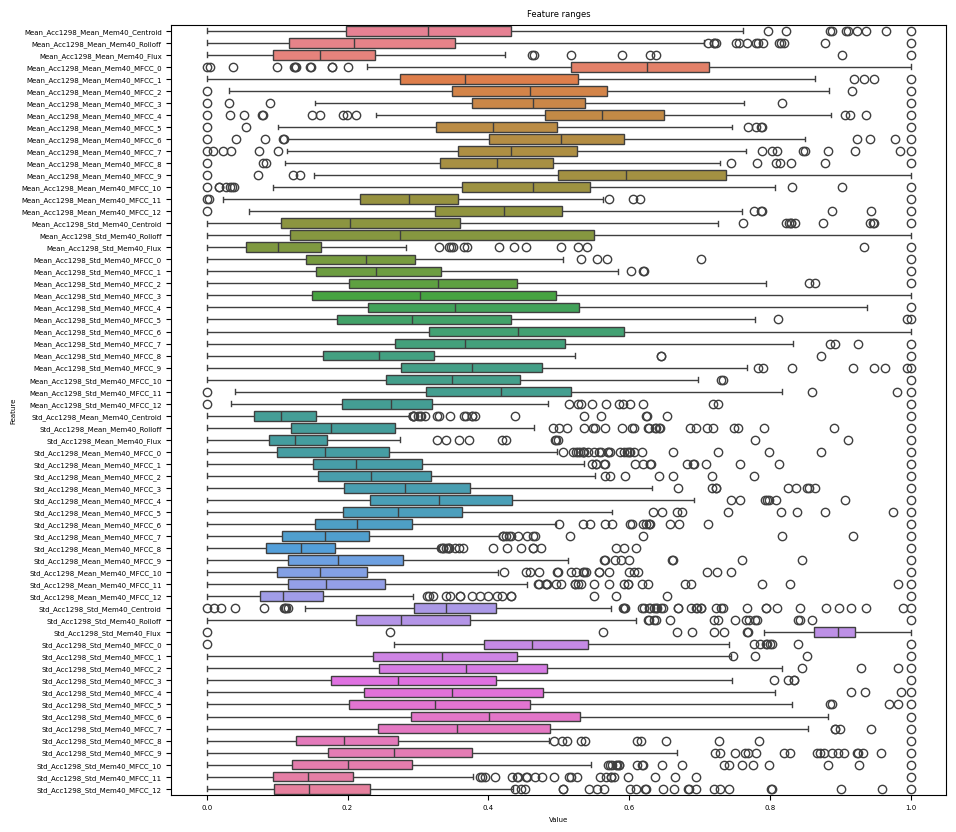

In [12]:
#recall that this was the distribution of our training data
plt.rcParams.update({'font.size': 5}) 
plt.figure(figsize=(10,10))
plt.title('Feature ranges')
sns.boxplot(data=train_df_scaled[audio_features], orient="h")
plt.xlabel('Value')
plt.ylabel('Feature')
plt.show()

# Creating my own data
Using .wav files and converting them into the same format as the train data. (see audioFileToData.ipynb for how i figured out the function)

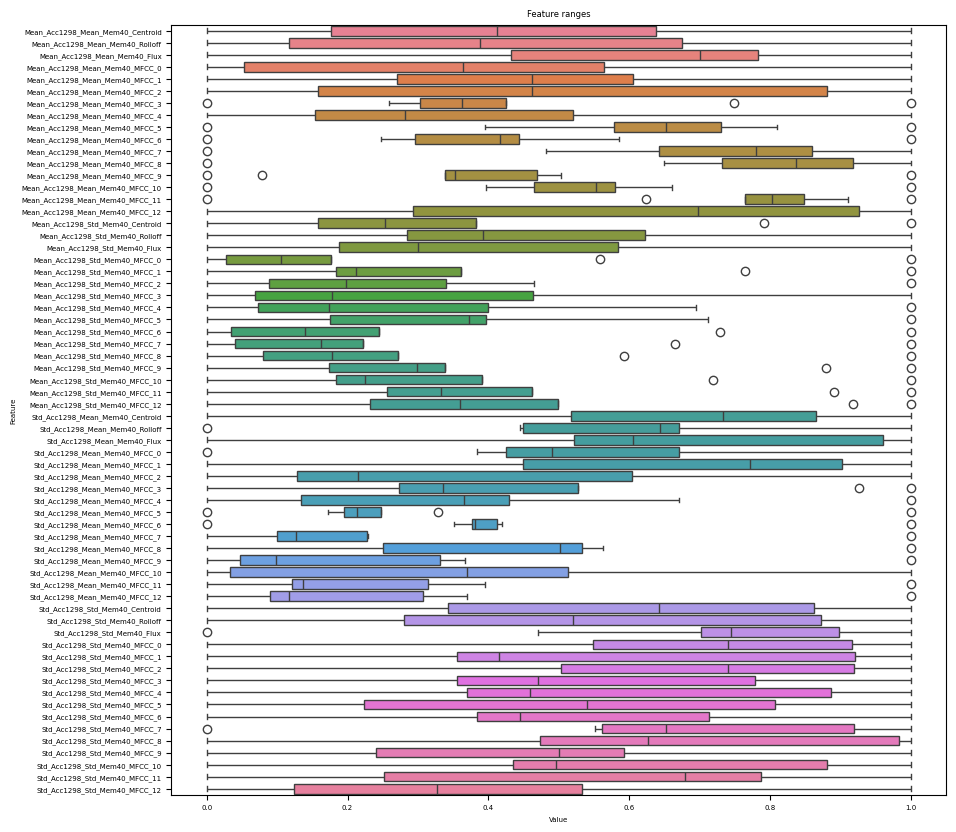

,Mean_Acc1298_Mean_Mem40_MFCC_12,Mean_Acc1298_Std_Mem40_MFCC_12,Std_Acc1298_Mean_Mem40_MFCC_12,Std_Acc1298_Std_Mem40_MFCC_12,Mean_Acc1298_Mean_Mem40_MFCC_11,Mean_Acc1298_Std_Mem40_MFCC_11,Std_Acc1298_Mean_Mem40_MFCC_11,Std_Acc1298_Std_Mem40_MFCC_11,Mean_Acc1298_Mean_Mem40_MFCC_10,Mean_Acc1298_Std_Mem40_MFCC_10,...,Std_Acc1298_Mean_Mem40_Centroid,Std_Acc1298_Std_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Std_Mem40_Rolloff,Std_Acc1298_Mean_Mem40_Rolloff,Std_Acc1298_Std_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Std_Mem40_Flux,Std_Acc1298_Mean_Mem40_Flux,Std_Acc1298_Std_Mem40_Flux
0,-8.607445,5.532482,10.927726,2.029824,-6.275976,5.450113,10.735990,2.150647,-11.487159,6.304918,...,638.543656,365.634272,2828.157585,1185.020342,1618.430566,753.382540,0.555475,0.369173,0.286014,0.256614
1,-4.960550,5.307951,6.185345,1.600839,0.528566,5.199827,4.801256,1.546083,-1.890569,5.551975,...,563.451490,446.511608,2985.503497,1018.000718,1185.507869,778.382470,1.046223,0.401067,0.344744,0.269379
2,-2.248950,7.162597,4.486582,2.464200,2.264014,7.173373,3.346786,2.510883,-4.464108,8.520124,...,401.789988,444.428192,4129.661482,1467.196312,946.372314,594.003279,1.490453,0.807760,0.343460,0.324896
3,-5.944823,7.410960,5.715649,3.454499,2.047415,6.890904,5.290861,2.894337,-3.282594,7.500075,...,552.464629,497.632779,3468.426265,1425.027851,1225.282086,729.092914,1.219505,0.644651,0.426592,0.345049
4,-0.170669,5.083169,4.285650,2.531350,2.972657,5.269887,3.760284,2.563578,0.180706,5.701682,...,699.488740,455.650176,3093.260278,1013.382128,1641.551436,726.197172,1.444722,0.556234,0.507962,0.314554


In [16]:
from myAudioData import audio_directory_to_df
my_audio_df = audio_directory_to_df('./data/movie_music/')
my_audio_df_scaled = my_audio_df.copy()

#normalize all the data before scaling it since this is a different data format
scaler2 = MinMaxScaler()
my_audio_df_scaled[audio_features] = scaler2.fit_transform(my_audio_df[audio_features])

plt.rcParams.update({'font.size': 5}) 
plt.figure(figsize=(10,10))
plt.title('Feature ranges')
sns.boxplot(data=my_audio_df_scaled[audio_features], orient="h")
plt.xlabel('Value')
plt.ylabel('Feature')
plt.show()

my_audio_df.head()

In [18]:
my_predictions  = model.predict(my_audio_df_scaled[audio_features])
# print(emotion_features)
# print(my_predictions)

#print out the predictions and the corresponding audio file names
for i in range(len(my_audio_df_scaled)):
    emotion_idx = my_predictions[i].argmax()
    print("File: " + my_audio_df_scaled['filename'].iloc[i] + " predicted emotion: " + emotion_features[emotion_idx])
   

File: ./data/movie_music/sad.wav predicted emotion: quiet-still
File: ./data/movie_music/8.wav predicted emotion: relaxing-calm
File: ./data/movie_music/6.wav predicted emotion: amazed-suprised
File: ./data/movie_music/7.wav predicted emotion: amazed-suprised
File: ./data/movie_music/5.wav predicted emotion: relaxing-calm
File: ./data/movie_music/4.wav predicted emotion: amazed-suprised
File: ./data/movie_music/space_odyssey.wav predicted emotion: amazed-suprised
File: ./data/movie_music/3.wav predicted emotion: amazed-suprised
File: ./data/movie_music/2.wav predicted emotion: relaxing-calm
